## Accurate Segmentation of Dermoscopic Images based on Local Binary Pattern Clustering!
https://arxiv.org/pdf/1902.06347.pdf

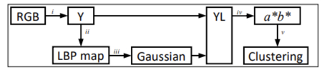

In [17]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage import color
from sklearn.cluster import KMeans
from image import load_image, compare_seg

plt.rcParams['figure.dpi'] = 200

In [58]:
def Y(img):
    n, m, _ = img.shape
    a = np.zeros(shape=(n, m))
    for i in range(n):
        for j in range(m):
            a[i, j] = (img[i, j][0] * 0.2989) + (img[i, j][1] * 0.5870) + (img[i, j][2] * 0.1140)
    return a

def g_index(i, j):
    indexes = []
    for b in range(j - 1, j + 2):
        for a in range(i - 1, i + 2):
            if (a != i) or (b != j):
                indexes.append((a, b))
    return indexes

def sum_lbp(X, i, j):
    def s(x):
        if x > 0:
            return 1
        else:
            return 0
    
    t = 0
    g = g_index(i, j)
    for p in range(7):
        t += s(X[g[p]] - X[i, j]) * (2 ** p)
    return t

def LBP_map(X):
    n, m = X.shape
    a = np.zeros(shape=(n - 2, m - 2))
    for i in range(1, n - 1):
        for j in range(1, m - 1):
            a[i - 1, j - 1] = sum_lbp(X, i, j)
    return a

def LYL(Y_, L_):
    n, m = Y_.shape
    a = np.zeros(shape=(n - 2, m - 2, 3))
    for i in range(1, n - 1):
        for j in range(1, m - 1):
            a[i - 1, j - 1] = np.array([L_[i - 1, j - 1], Y_[i, j], L_[i - 1, j - 1]])
    return a

def ab_tuples(LYL_):
    t = []
    for l in LYL_[:,:,1:3]:
        t += list(l)
    return np.array(t)

def clustering(X, shape):
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
    binary_labels = kmeans.labels_
    return binary_labels.reshape(*shape)

def reverse_binary(data):
    x1, y1 = (data == 1).nonzero()
    x2, y2 = (data == 0).nonzero()

    data[x1, y1] = 0
    data[x2, y2] = 1
    return data

def metric2(TPR, FPR):
    return ((1 + (1 - TPR)) ** 2) + ((1 + FPR) ** 2) - 2

def metric1(TPR, FPR):
    return 1 - TPR + FPR

def biggest_contour(img):
    mask = np.zeros(img.shape, np.uint8)
    cnts, _ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    c_sizes = [(cv2.contourArea(c), c) for c in cnts]
    bc = max(c_sizes, key=lambda x: x[0])[1]
    cv2.drawContours(mask, [bc], -1, 255, -1)
    return mask

def main(filename):
    img = cv2.imread(filename)
    y = Y(img)
    lbp = LBP_map(y)
    gaussian = gaussian_filter(lbp, sigma=4)
    lyl = LYL(y, gaussian)
    lab = color.rgb2lab(lyl)
    X = ab_tuples(lab)
    C = clustering(X, lab.shape[:2]).astype('uint8')
    s = C.shape
    if np.sum(C) > (s[0] * s[1]) / 2:
        C = reverse_binary(C)
    return C * 255

[IMG 1]


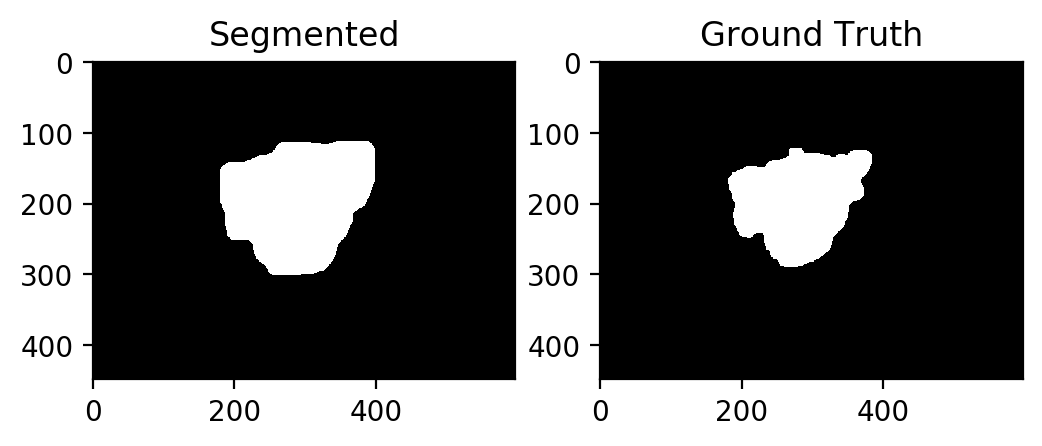

TPR: 1.0
FPR: 0.0346496077287433

[IMG 2]


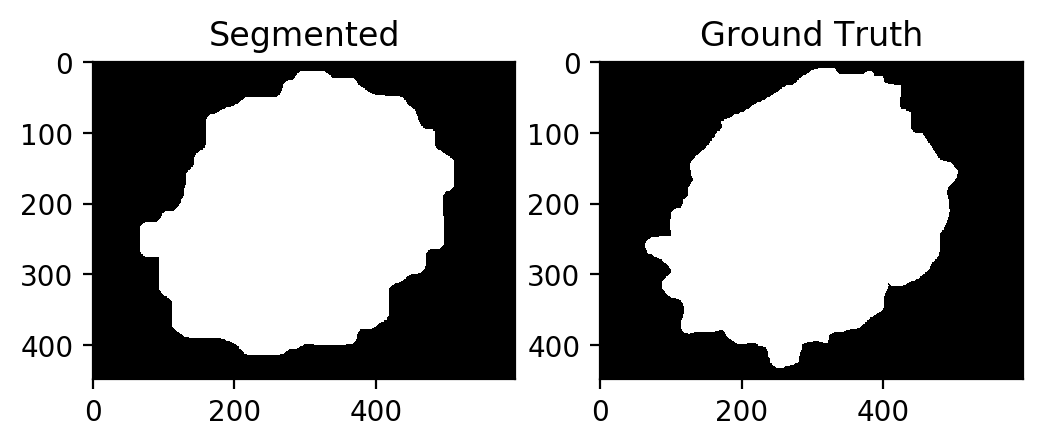

TPR: 0.9702188312232749
FPR: 0.05668285856533498

[IMG 3]


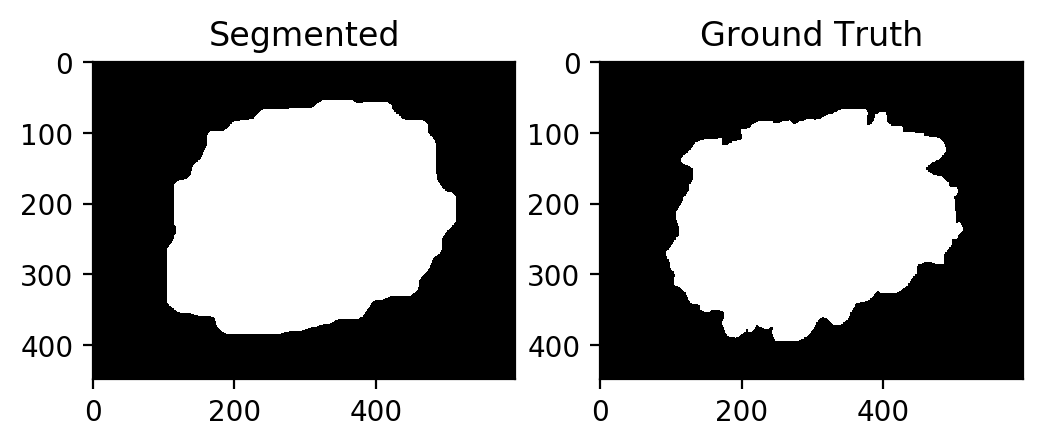

TPR: 0.9687662304597994
FPR: 0.06170562551190567

[IMG 4]


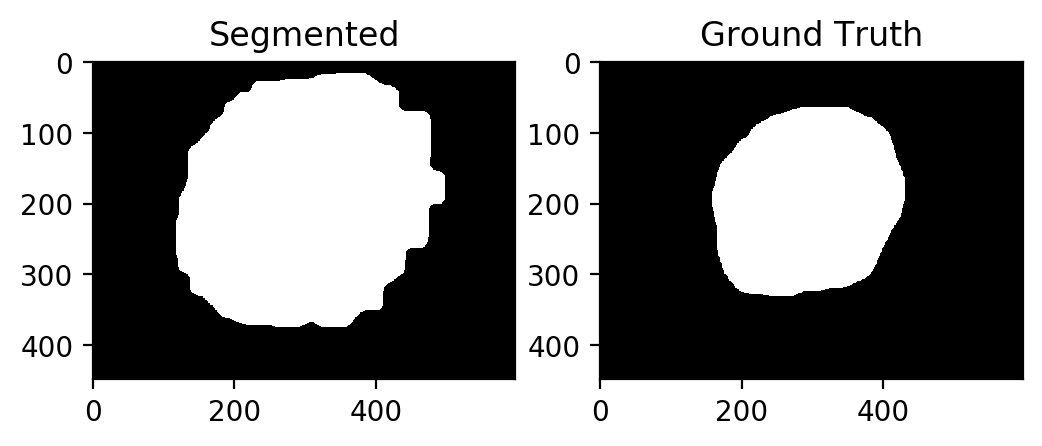

TPR: 1.0
FPR: 0.22908310345981556

[IMG 5]


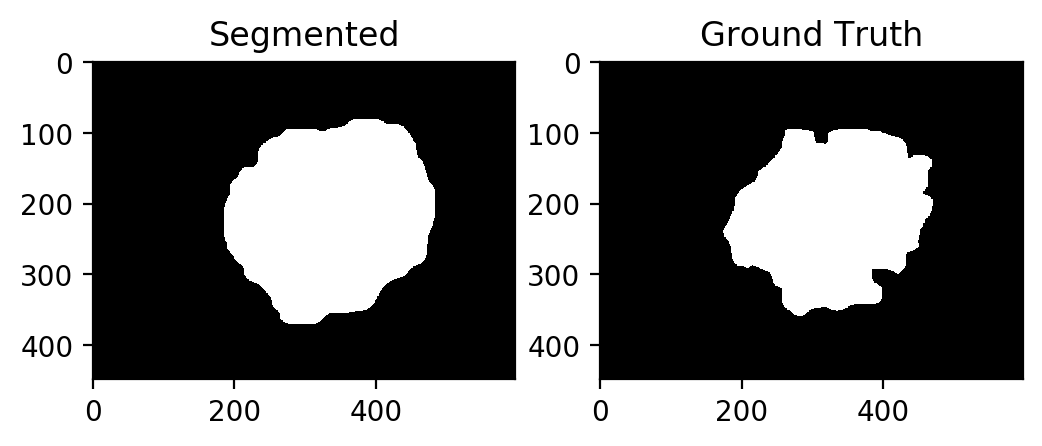

TPR: 0.9864318235411489
FPR: 0.04848313946657267

[IMG 6]


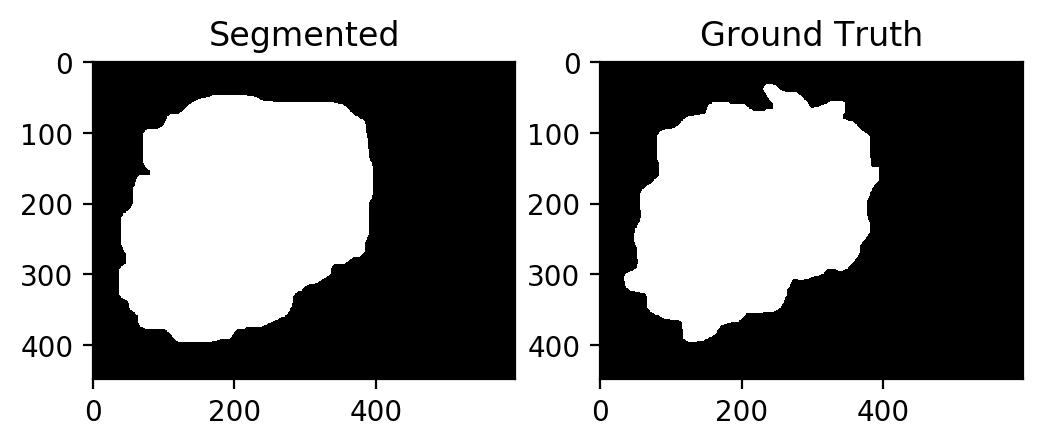

TPR: 0.9873827166158152
FPR: 0.0661513263465433

[IMG 7]


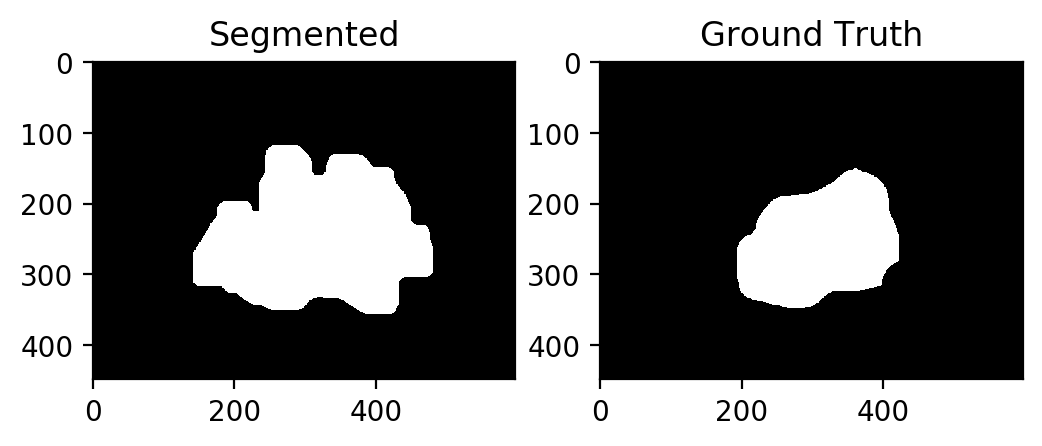

TPR: 0.9981560195024378
FPR: 0.10086983061193347

[IMG 8]


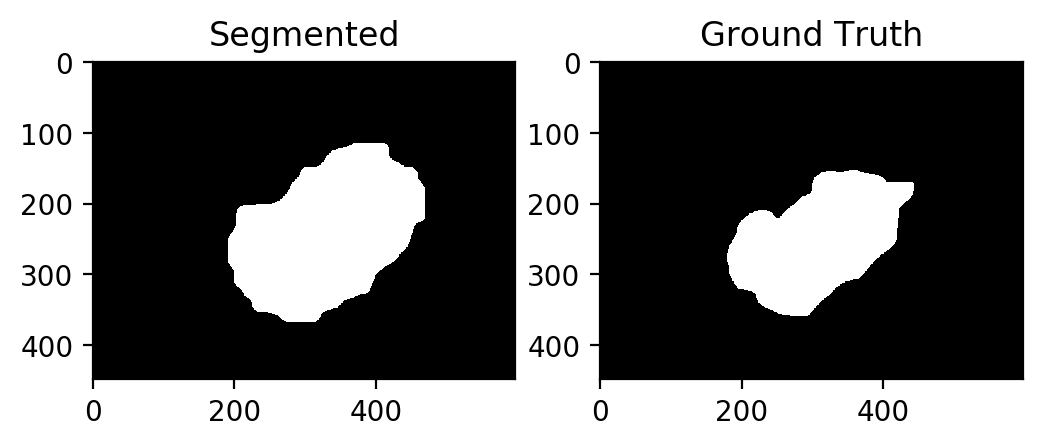

TPR: 0.9723411261112941
FPR: 0.06049117899162889

[IMG 9]


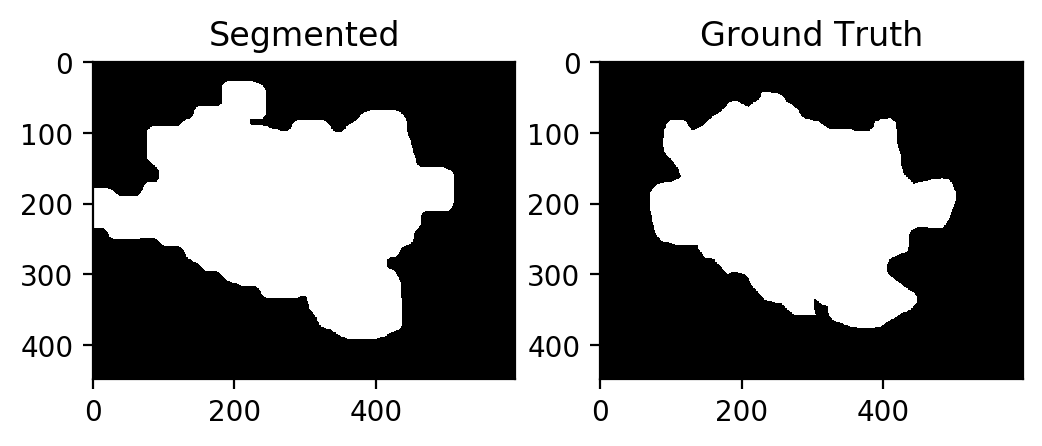

TPR: 0.95113129222174
FPR: 0.09915698311158039

[IMG 10]


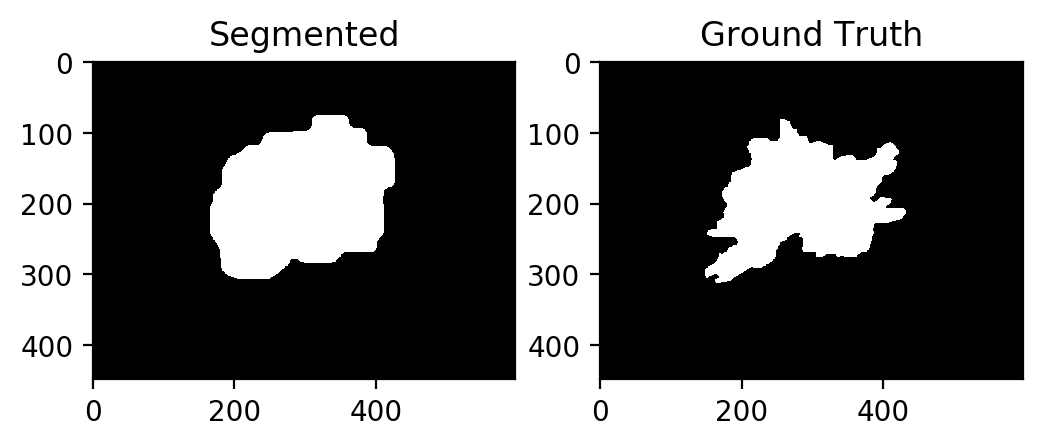

TPR: 0.9371226375354546
FPR: 0.04688434964161949

[IMG 11]


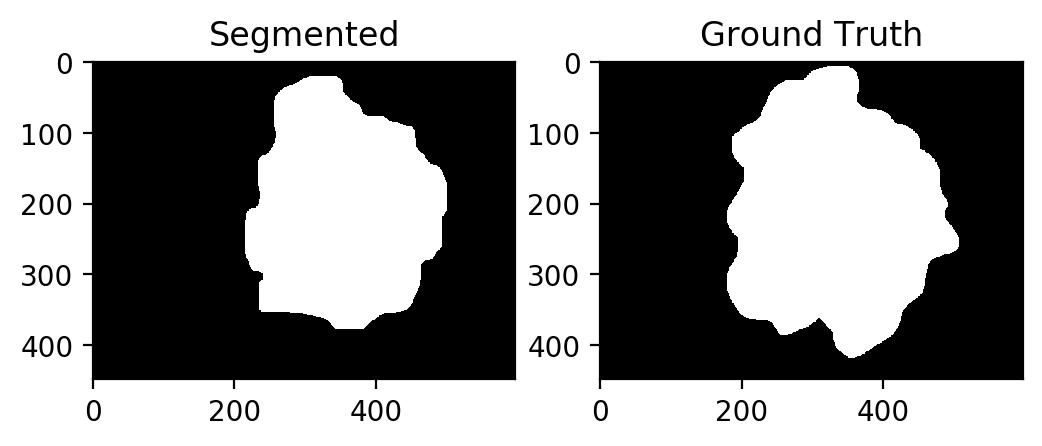

TPR: 0.7820721995915677
FPR: 0.010584243391976276

[IMG 12]


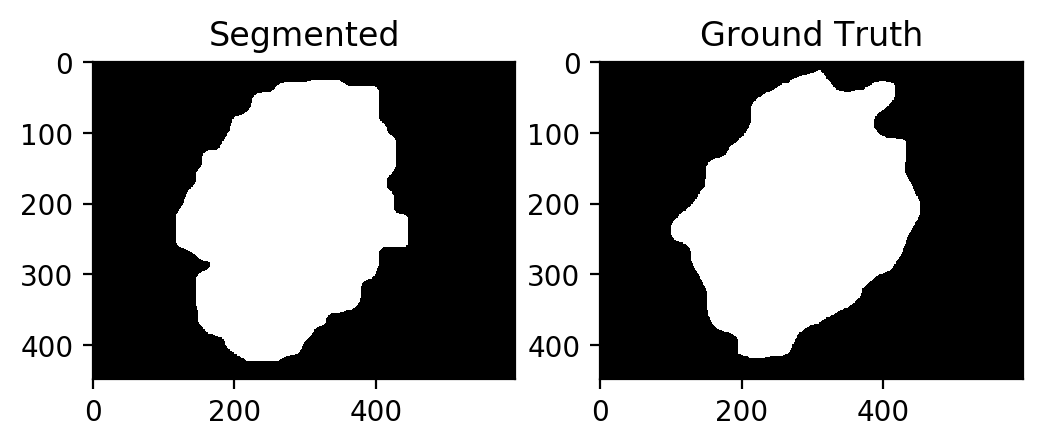

TPR: 0.9460314650498971
FPR: 0.03203618787953898

[IMG 13]


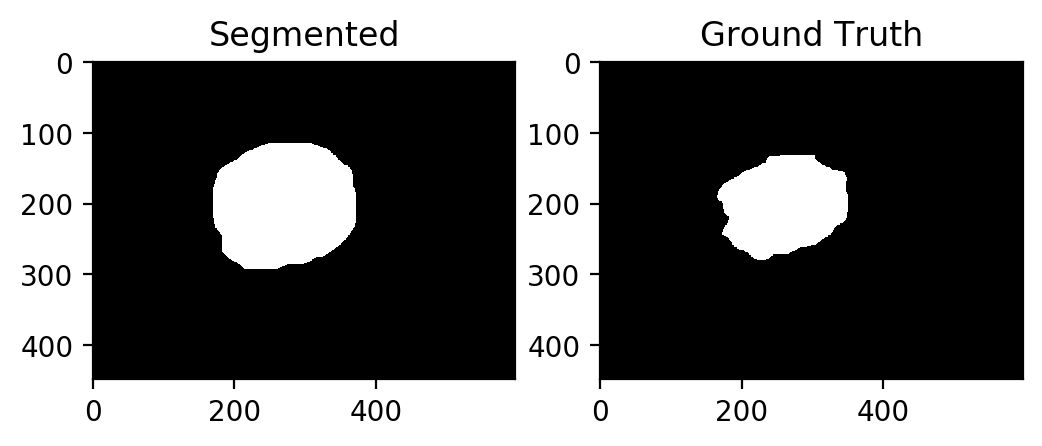

TPR: 0.9946172839506173
FPR: 0.03869107706719859

[IMG 14]


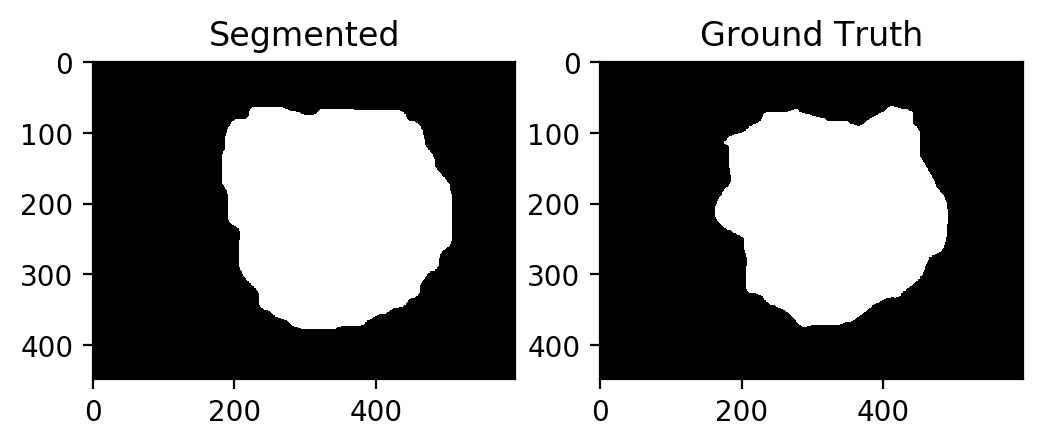

TPR: 0.9666852116780587
FPR: 0.05132216285886535

[IMG 15]


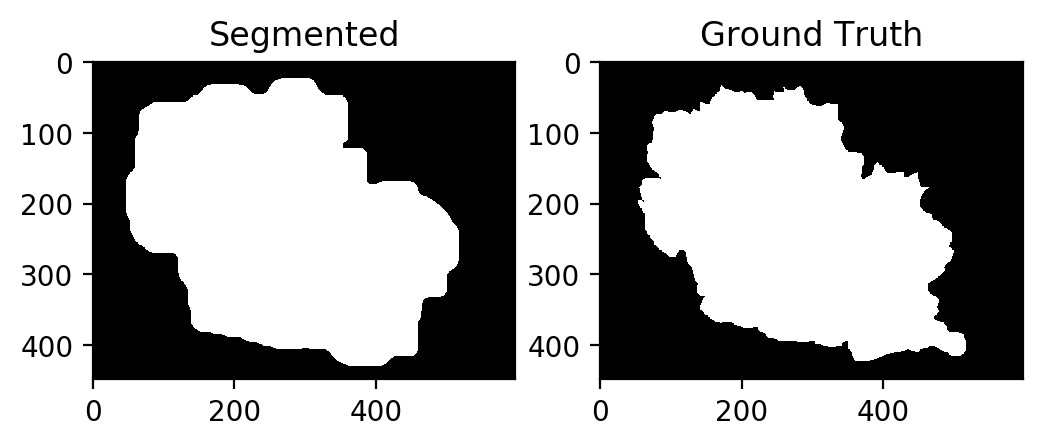

TPR: 0.9713565168984742
FPR: 0.11314892562758214

[IMG 16]


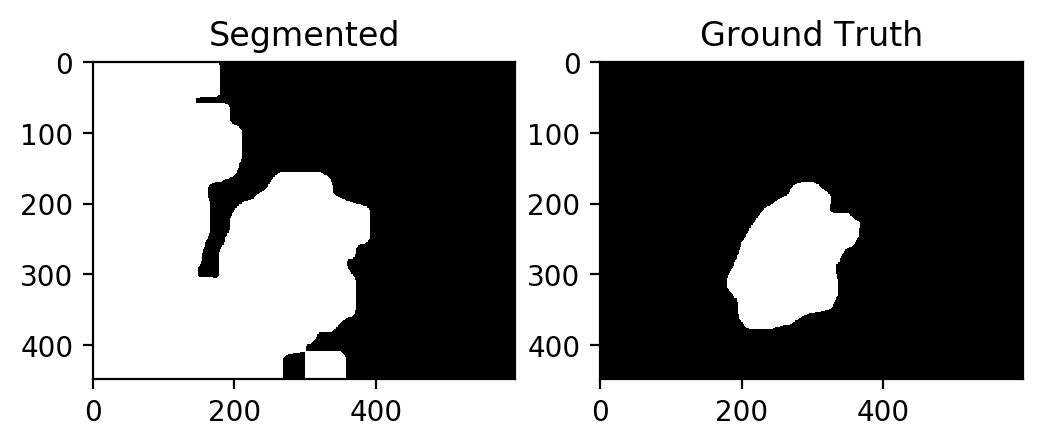

TPR: 1.0
FPR: 0.42445215282389287

[IMG 17]


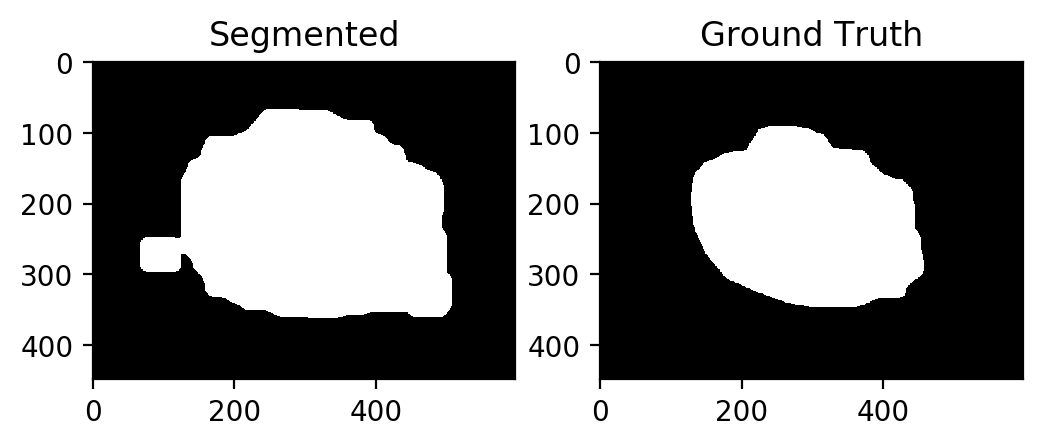

TPR: 1.0
FPR: 0.1556002978464915

[IMG 18]


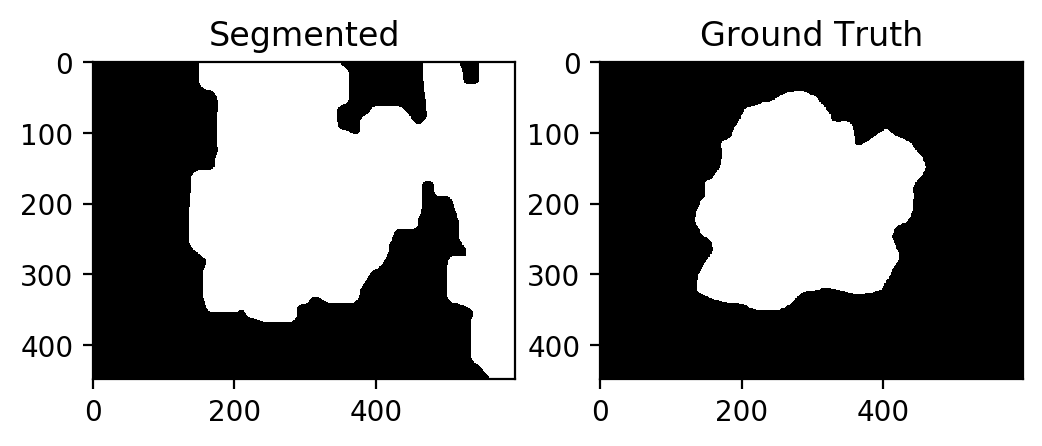

TPR: 0.9733608282131134
FPR: 0.33933820911615414

[IMG 19]


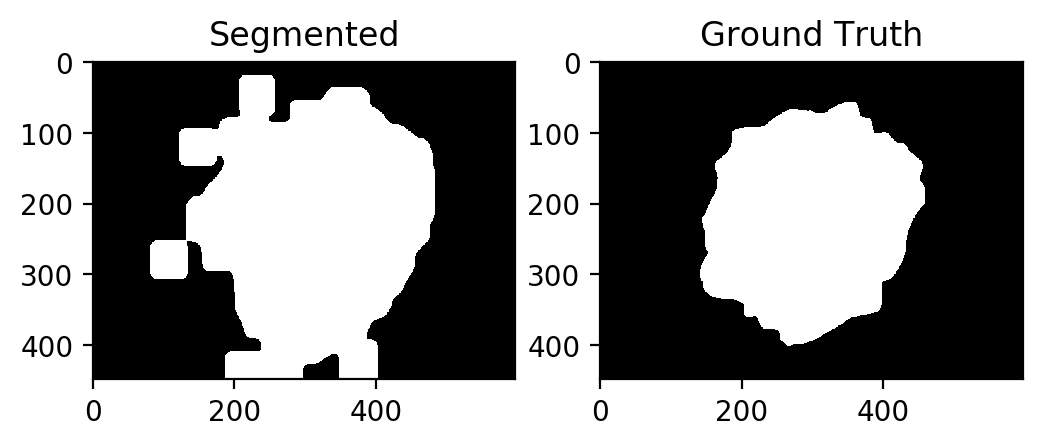

TPR: 0.959828896124625
FPR: 0.18857106688679195

[IMG 20]


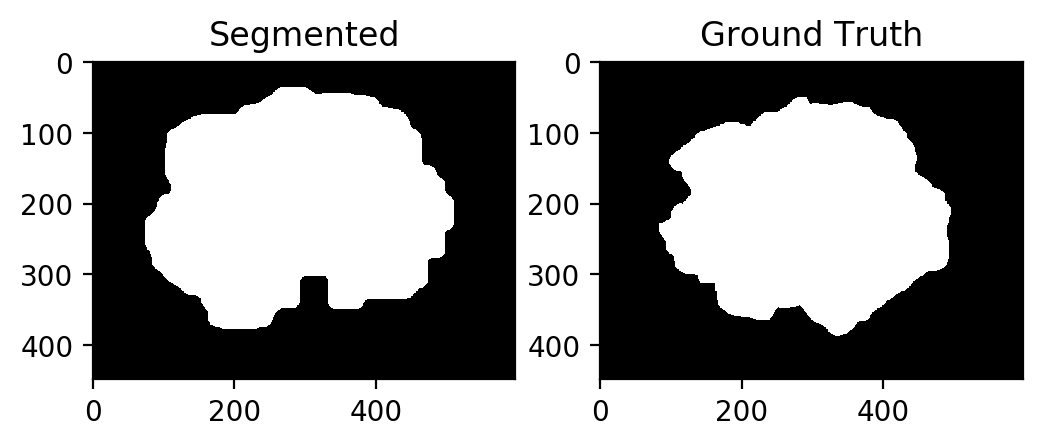

TPR: 0.9513348792349839
FPR: 0.09858485584539022

[IMG 21]


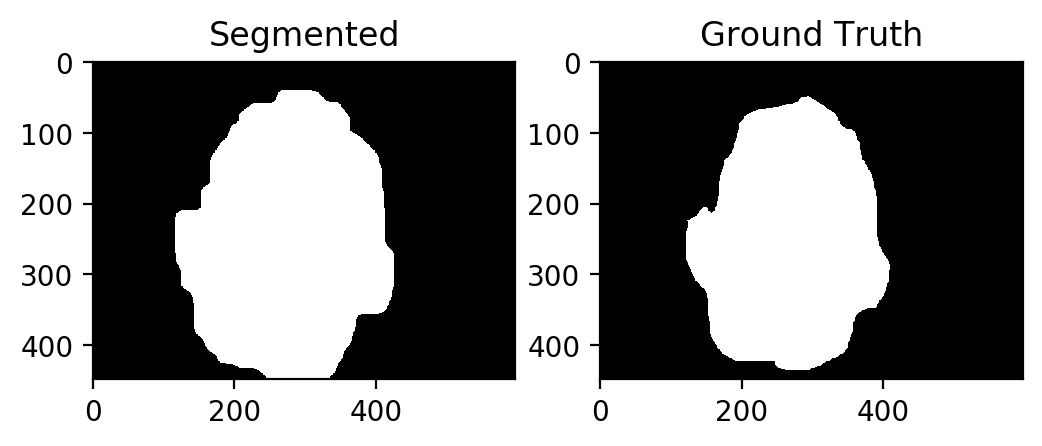

TPR: 0.9991334597561129
FPR: 0.07578195955958508

[IMG 22]


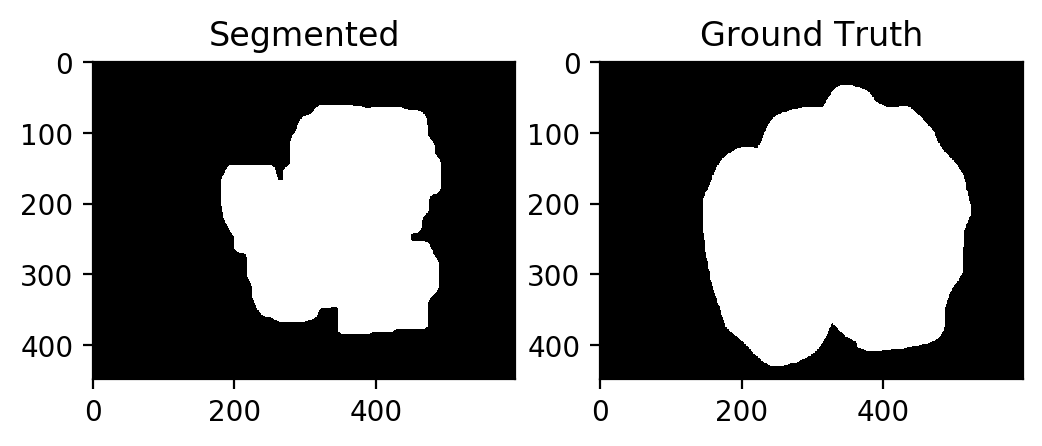

TPR: 0.6840229956549941
FPR: 0.0025939585867753166

[IMG 23]


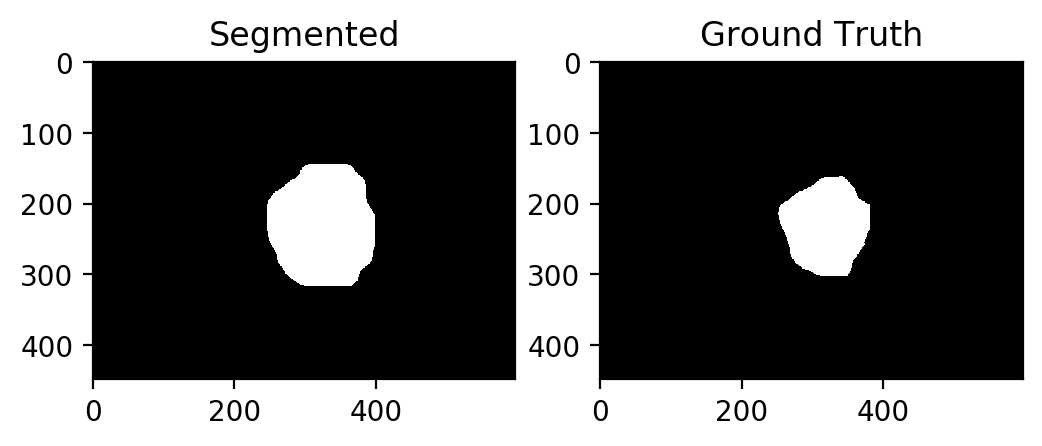

TPR: 1.0
FPR: 0.032164386145539424

[IMG 24]


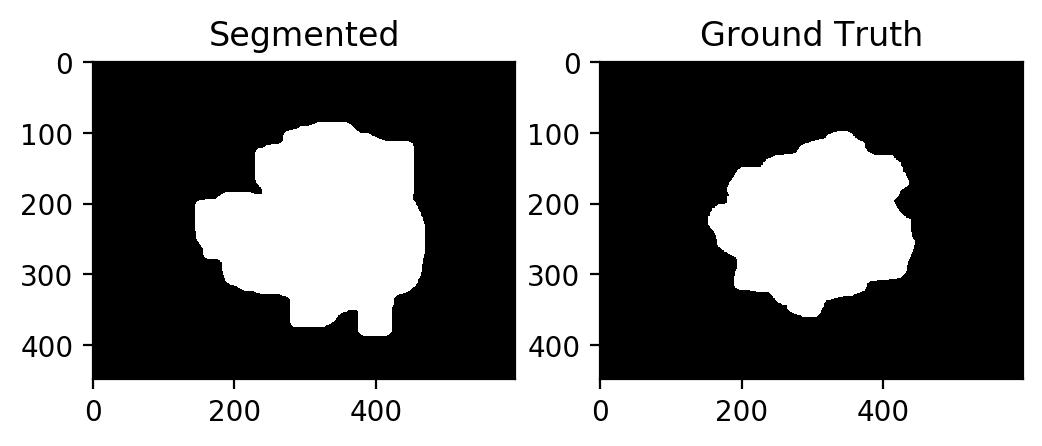

TPR: 0.9552700314972727
FPR: 0.08455957300913657

[IMG 25]


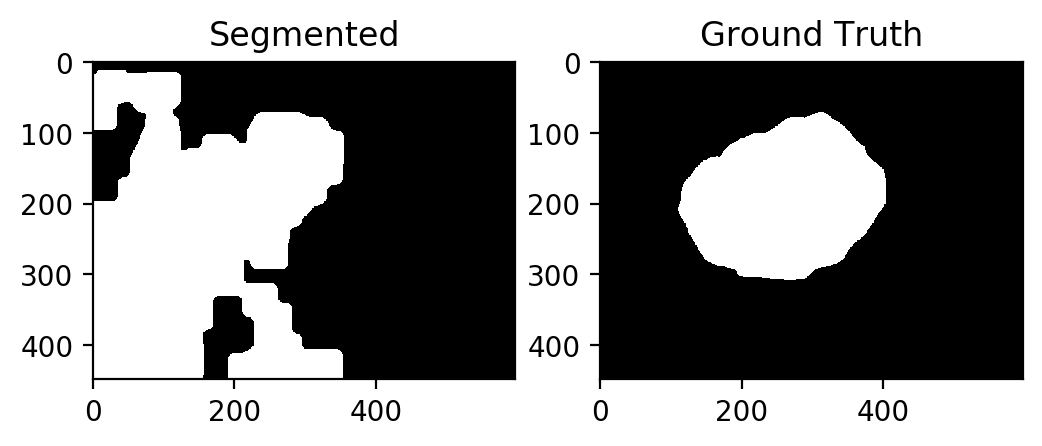

TPR: 0.7297558812264399
FPR: 0.32304612523305404

[IMG 26]


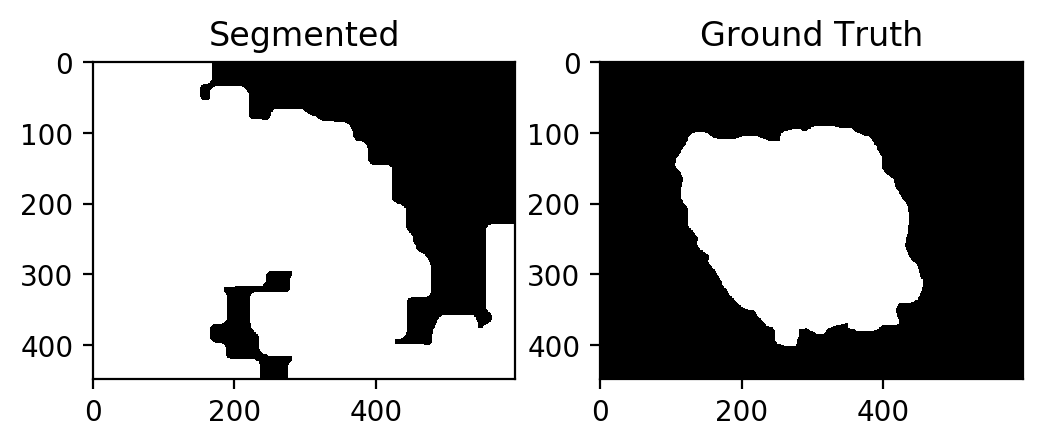

TPR: 0.9666014820913956
FPR: 0.5843271495877503

[IMG 27]


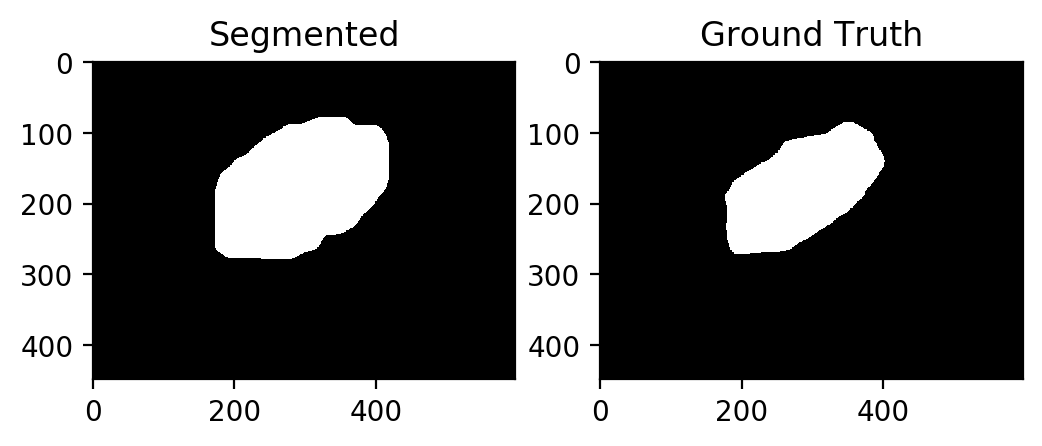

TPR: 1.0
FPR: 0.04506180769374215

[IMG 28]


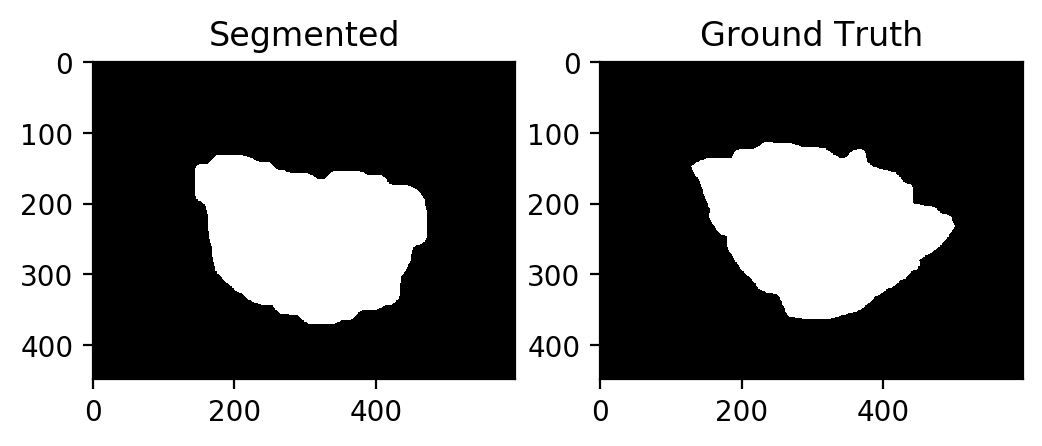

TPR: 0.8651363938789088
FPR: 0.02498267431563547

[IMG 29]


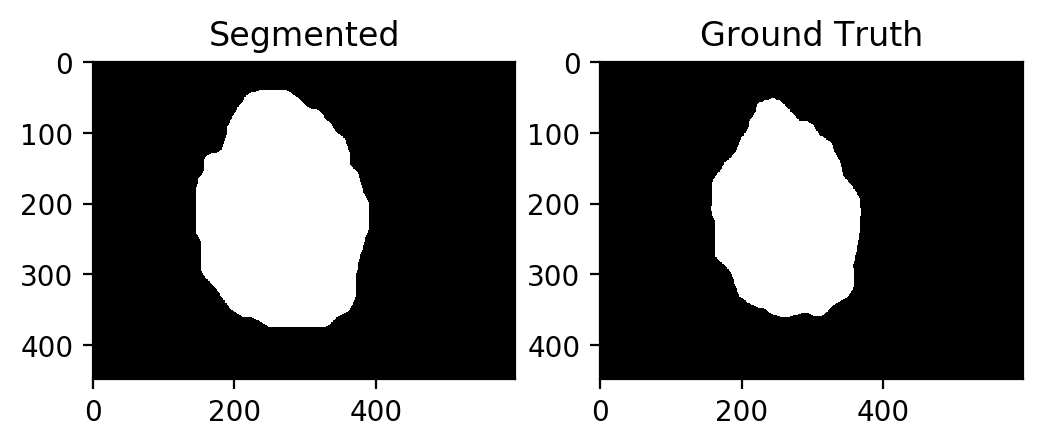

TPR: 1.0
FPR: 0.07244605395286281

[IMG 30]


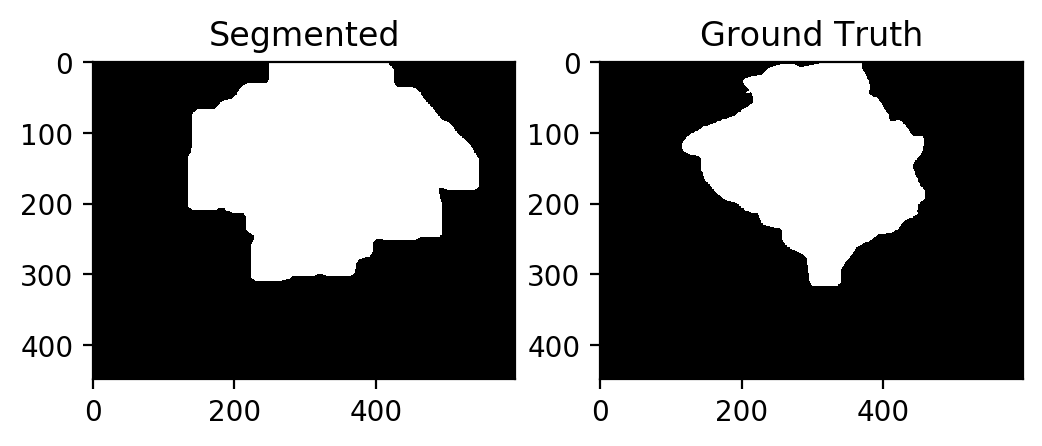

TPR: 0.9691347455912338
FPR: 0.13440245118017058

[IMG 31]


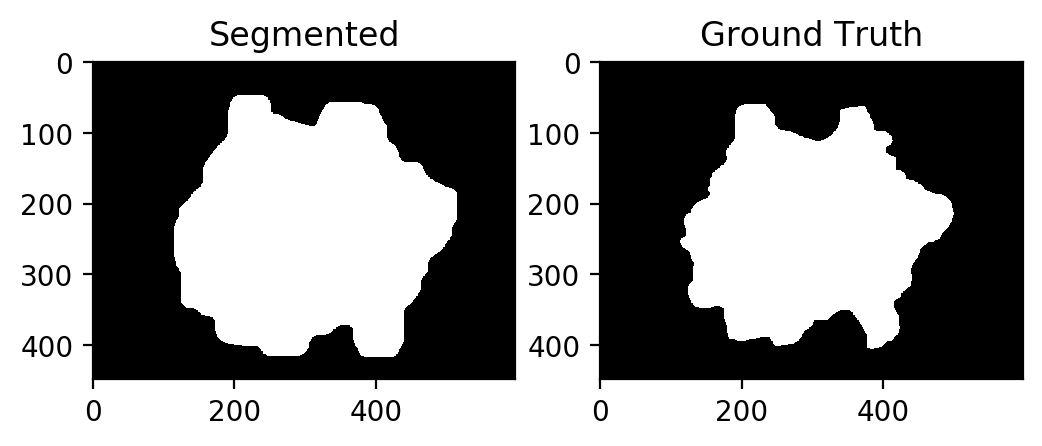

TPR: 0.9998181632212385
FPR: 0.10559548226087054

[IMG 32]


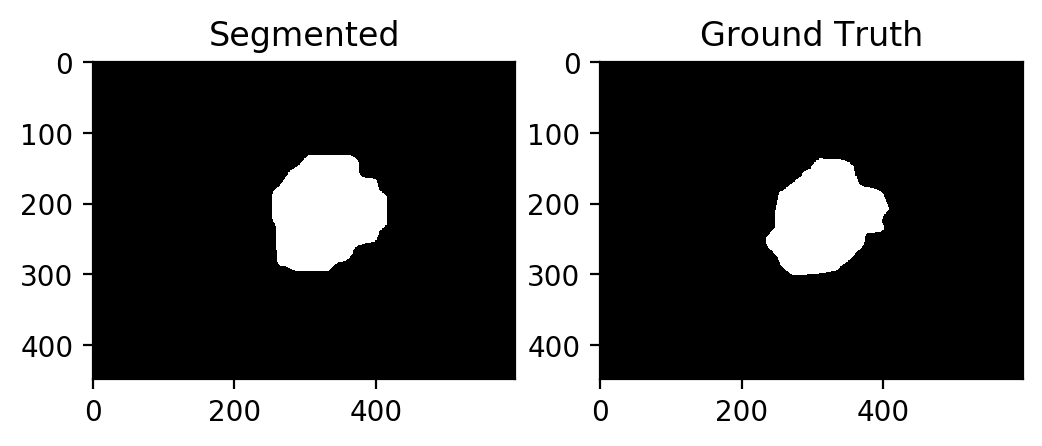

TPR: 0.9219476516378454
FPR: 0.012140069061717378

[IMG 33]


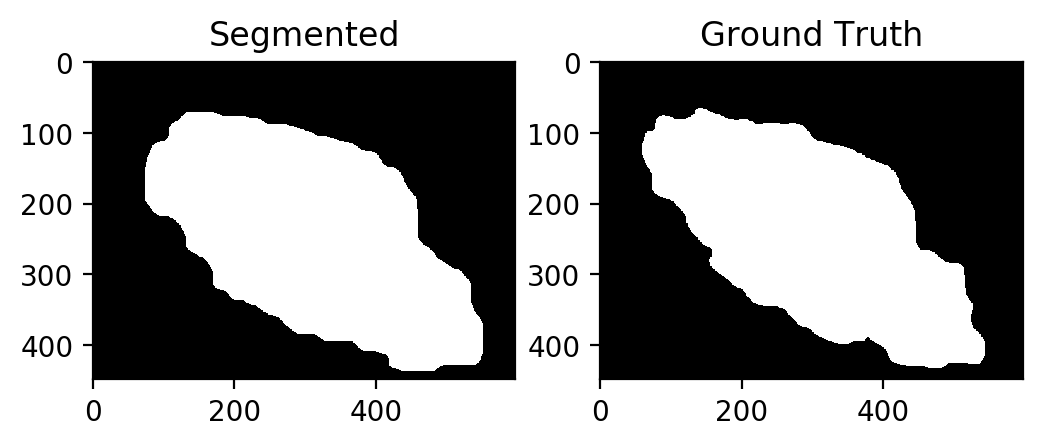

TPR: 0.9740242840412008
FPR: 0.053403808265328596

[IMG 34]


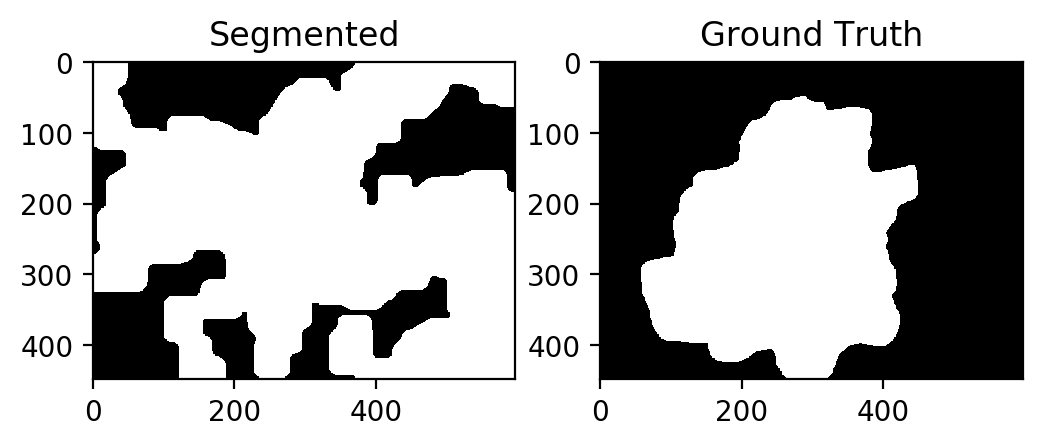

TPR: 0.8177107000937841
FPR: 0.6357865937072503

[IMG 35]


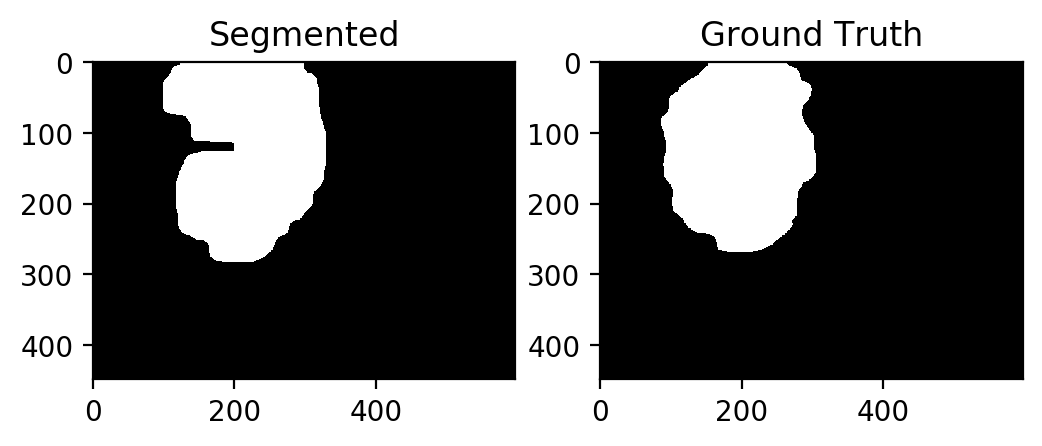

TPR: 0.8779227434818817
FPR: 0.04178257860525709

[IMG 36]


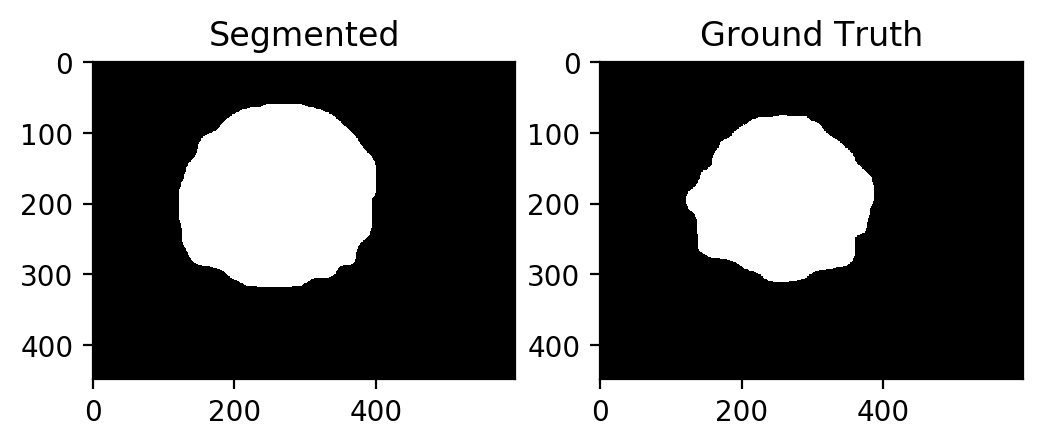

TPR: 1.0
FPR: 0.05463927273709662

[IMG 37]


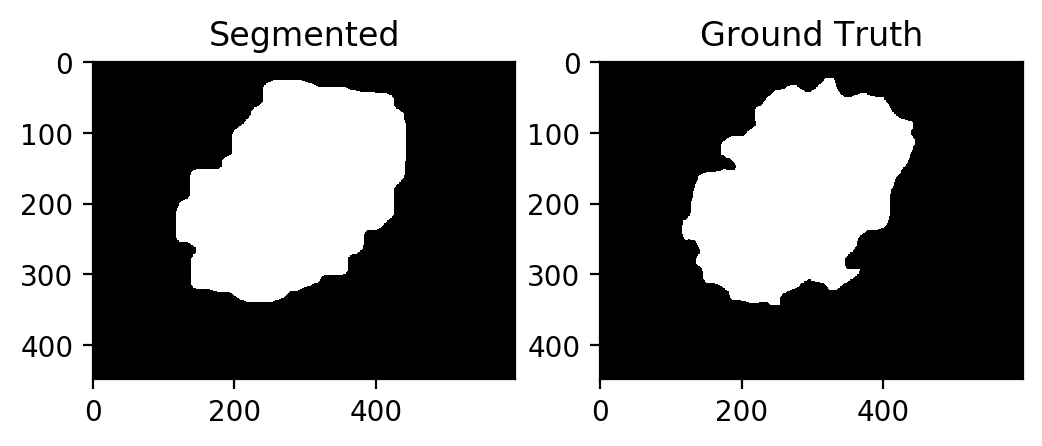

TPR: 0.9666808304883588
FPR: 0.029956675264831836

[IMG 38]


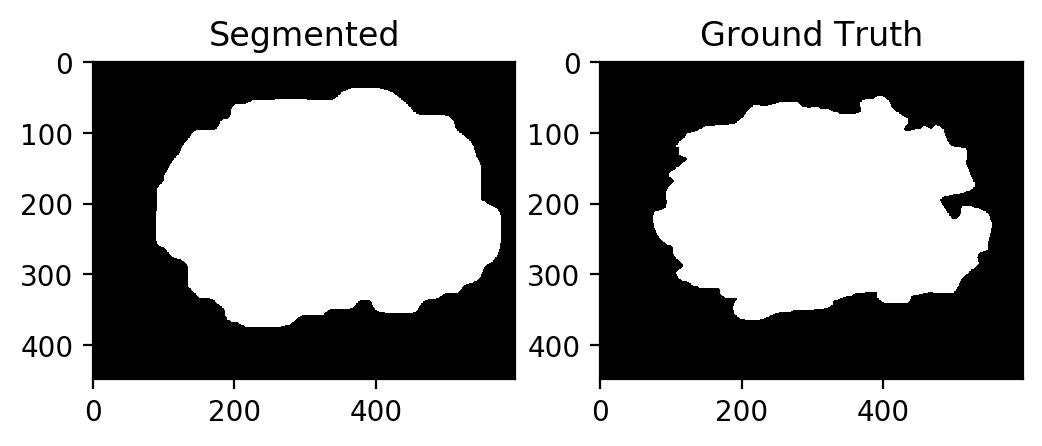

TPR: 0.9820597459835594
FPR: 0.11323884673365249

[IMG 39]


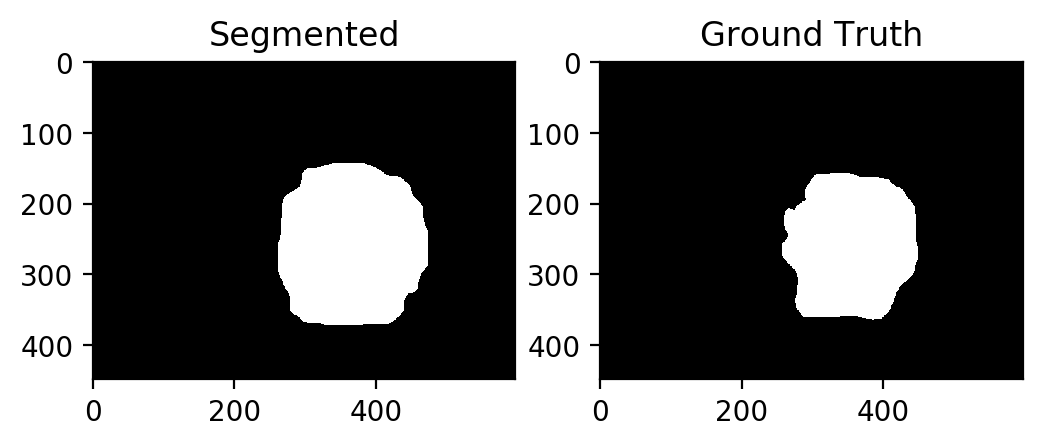

TPR: 0.9902404041033956
FPR: 0.03761136058142838

[IMG 40]


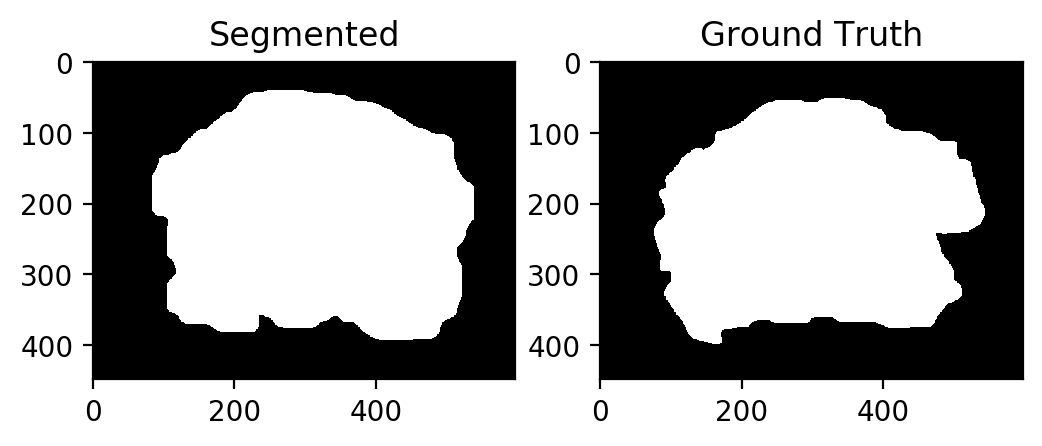

TPR: 0.9628311388771353
FPR: 0.087790843641644

[IMG 41]


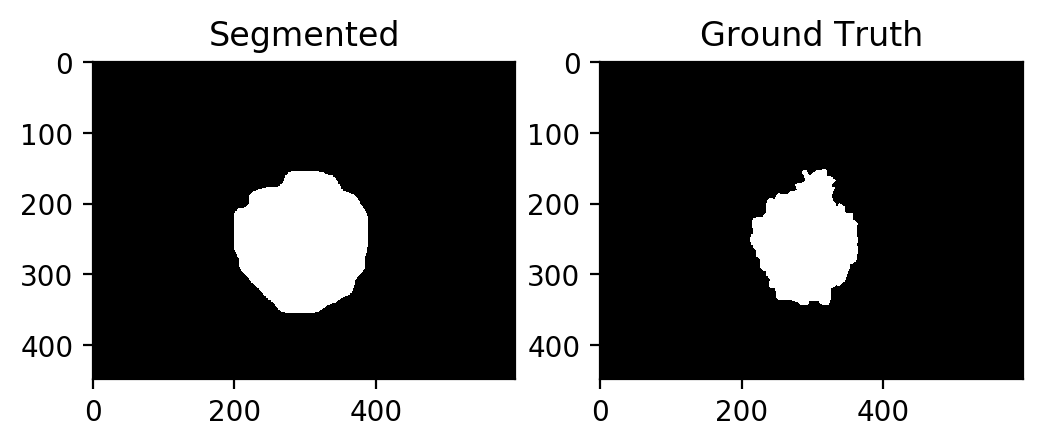

TPR: 0.9976983888722105
FPR: 0.03829088650279528

[IMG 42]


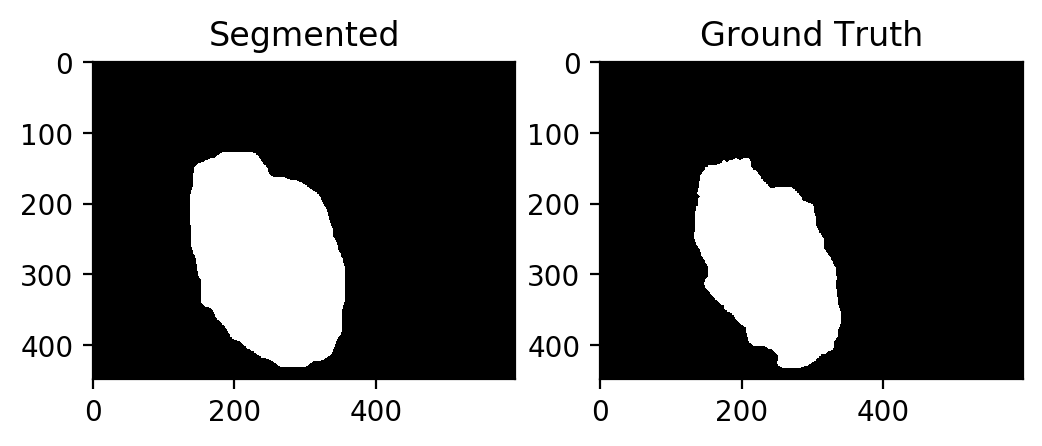

TPR: 0.9910971395661355
FPR: 0.04131599420064359

[IMG 43]


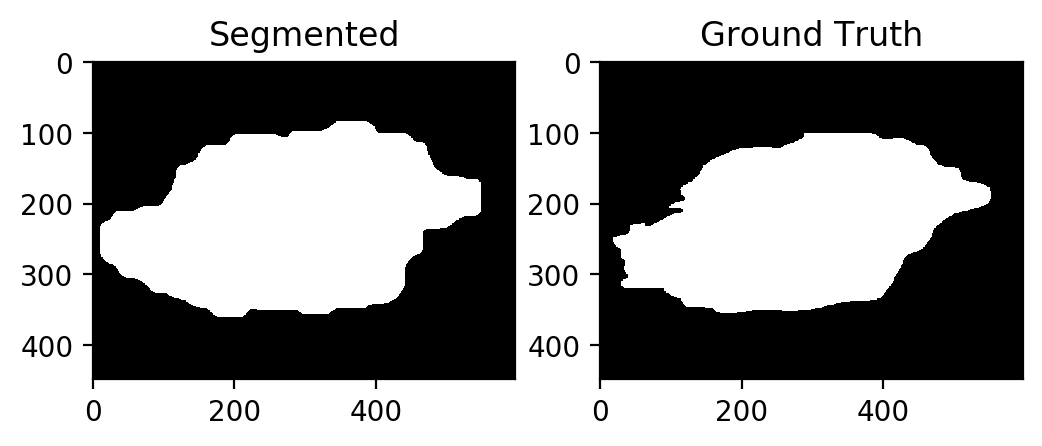

TPR: 0.9858424681259986
FPR: 0.06875136622741872

[IMG 44]


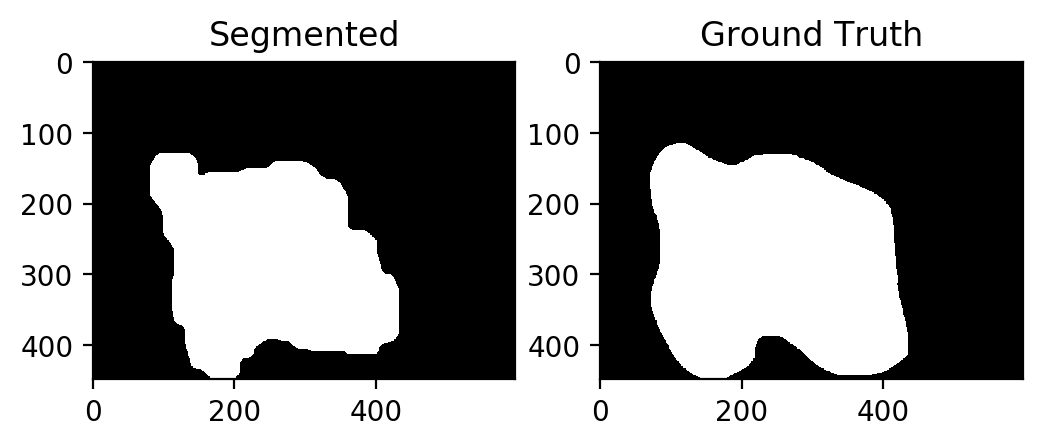

TPR: 0.800900133045069
FPR: 0.006616345168204268

[IMG 45]


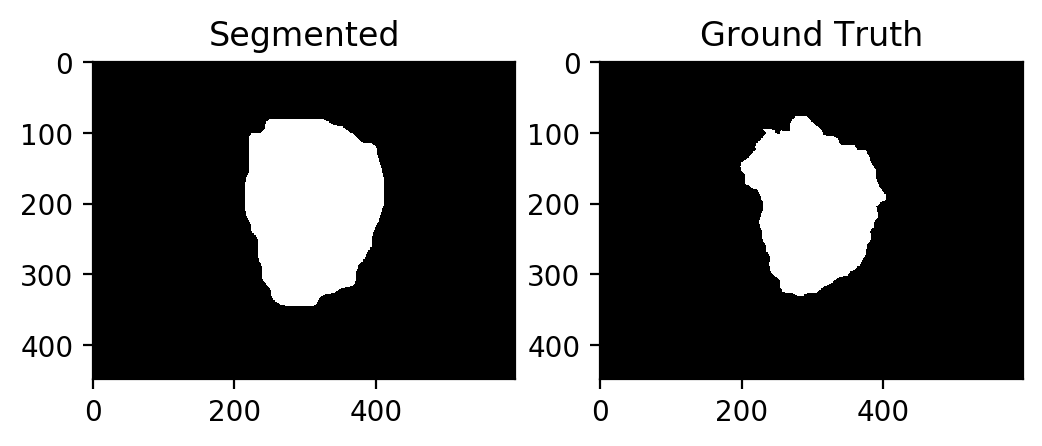

TPR: 0.97585281717133
FPR: 0.03479680495070239

[IMG 46]


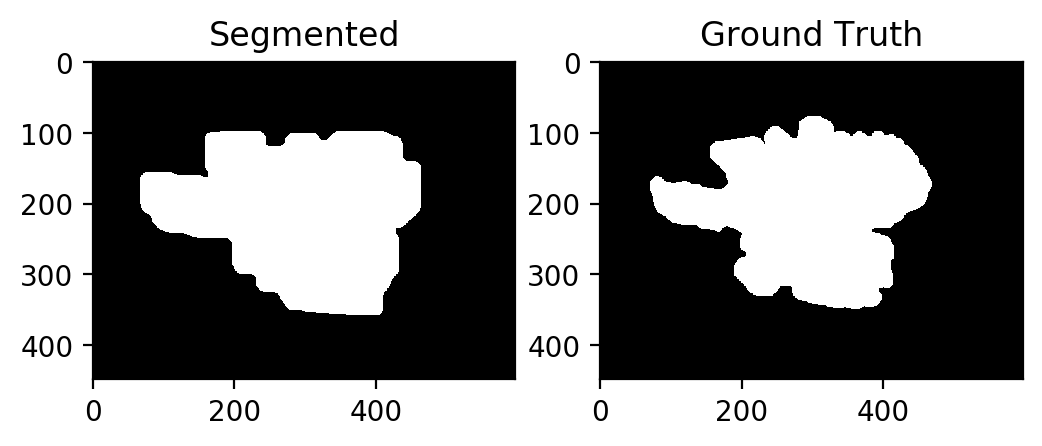

TPR: 0.9490094136467114
FPR: 0.046749009325158214

[IMG 47]


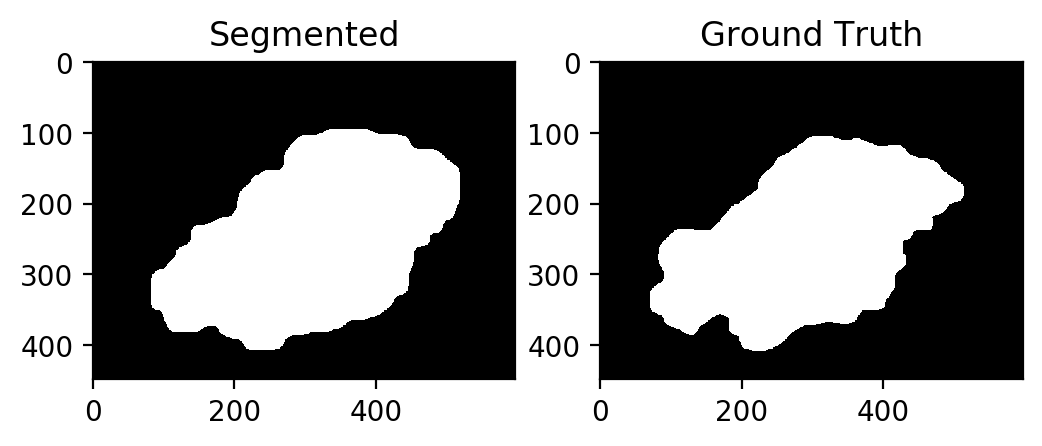

TPR: 0.9511349068697685
FPR: 0.058267582750161945

[IMG 48]


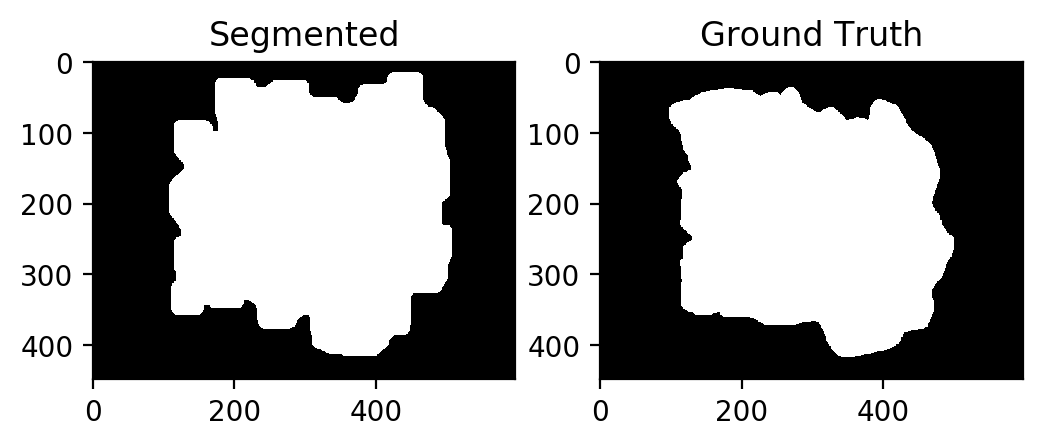

TPR: 0.9522469976945047
FPR: 0.10950151655017804

[IMG 49]


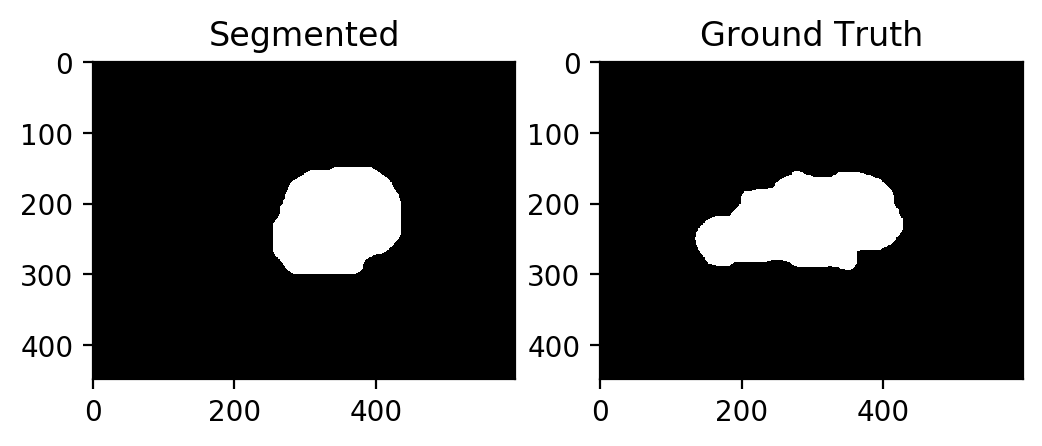

TPR: 0.6283300401989508
FPR: 0.01763990777614756

[IMG 50]


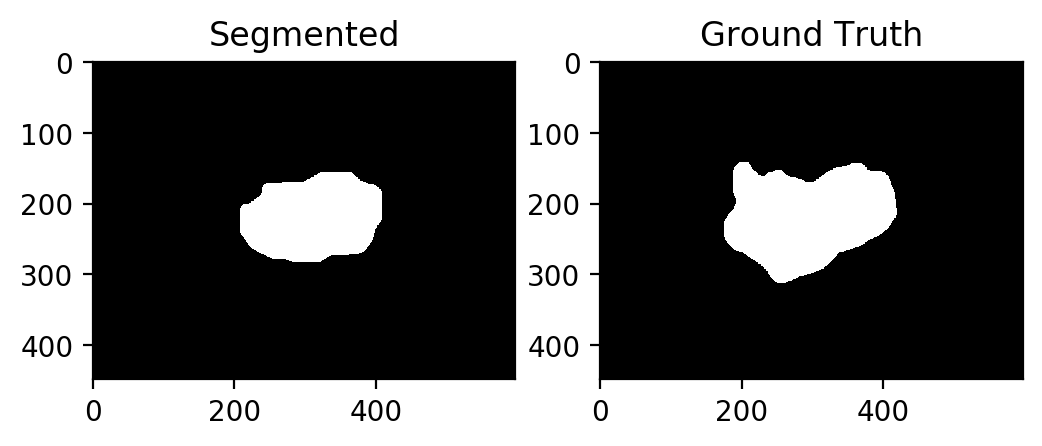

TPR: 0.6779094076655052
FPR: 0.0027549706526646713

Avg TPR: 0.9377830064486649
Avg FPR: 0.10464966474013931


In [59]:
img_folder = "images/original"
seg_folder = "images/segmented"

avg_TPR = 0
avg_FPR = 0
avg_TP = 0
avg_TN = 0
avg_FP = 0
avg_FN = 0
cont = 0

for img_name in sorted(os.listdir(img_folder)):
    cont += 1
    aux_index = img_name.index("i")
    n = img_name[0:aux_index]
    img_path = img_folder + "/" + img_name
    func_seg_img = main(img_path)
    
    # Improve the segmentation by applying morphology operations
    func_seg_img = cv2.erode(func_seg_img, np.ones((5,5),np.uint8), iterations=2)
    func_seg_img = cv2.dilate(func_seg_img, np.ones((5,5),np.uint8), iterations=4)
    
    opening = cv2.morphologyEx(func_seg_img, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))
    final = cv2.morphologyEx(opening, cv2.MORPH_DILATE, np.ones((5,5),np.uint8),iterations=3)
    final = cv2.medianBlur(final,9)
    final = cv2.morphologyEx(final, cv2.MORPH_DILATE, np.ones((7,7),np.uint8),iterations=3)
    final = cv2.medianBlur(final,11)
    func_seg_img = cv2.morphologyEx(final, cv2.MORPH_CLOSE, np.ones((7,7),np.uint8))
    
    func_seg_img = biggest_contour(func_seg_img)
                
    real_seg_path = seg_folder + "/" + n + "seg.png"
    real_seg_img = load_image(real_seg_path)
    s = real_seg_img.shape
    real_seg_img = real_seg_img[1:s[0] - 1, 1:s[1] - 1]
    print(f'[IMG {cont}]')
    figure, axis = plt.subplots(1, 2)
    plt.subplots_adjust(hspace=1)
    axis[0].imshow(func_seg_img, cmap='gray')
    axis[0].set_title('Segmented')
    axis[1].imshow(real_seg_img, cmap='gray')
    axis[1].set_title('Ground Truth')
    plt.show()
    
    # Compare
    TPR, FPR, TP, TN, FP, FN = compare_seg(real_seg_img, func_seg_img)
    
    print(f'TPR: {TPR}')
    print(f'FPR: {FPR}\n')
    avg_TPR += TPR
    avg_FPR += FPR
    
print("Avg TPR:", avg_TPR/cont)
print("Avg FPR:", avg_FPR/cont)

In [60]:
print(metric1(avg_TPR / cont, avg_FPR / cont) * 100)
print(metric2(avg_TPR / cont, avg_FPR / cont))

16.686665829147447
0.34855582319973966
